"Detecting Bundling Opportunities Using Cointegration and Revenue Impact Simulation"
--

Project Objectives
--
1. Identify Cointegrated Department Pairs:
Use Engle-Granger cointegration tests to find product categories that move together in the long run, forming potential bundle candidates.

2. Estimate Long-Run Relationships (OLS):
Fit regression models for each cointegrated pair to compute bundle ratios (slope coefficients).

3. Detect Bundling Opportunities Based on Z-Score Spreads:
Monitor deviations from long-run trends using z-scores of residual spreads to suggest bundling weeks (signals where one category underperforms).

4. Simulate Revenue Uplift from Bundling Strategy:
Apply a hypothetical uplift (e.g., 5%) to simulate increased revenue and use a paired t-test to check statistical significance.





📌 Introduction\
This analysis explores a data-driven strategy to detect product bundling opportunities by leveraging cointegration in sales patterns across departments. Using weekly sales data, we test for stationarity, identify long-run cointegrated category pairs, and estimate their bundle ratios through regression models. Residual analysis and z-score thresholds are then used to generate bundling signals when one category significantly underperforms its partner. Finally, a simulated revenue uplift is tested using paired t-tests to assess the statistical viability of such bundling strategies.

Loading CSV files to Dataframes
-------------------------------




In [22]:
import pandas as pd

df_order = pd.read_csv("2_orders.csv")
df_order_prior = pd.read_csv("2_order_products__prior.csv")
df_order_train = pd.read_csv("2_order_products__train.csv")
df_product = pd.read_csv("2_products.csv")
df_department = pd.read_csv("2_departments.csv")
df_aisles = pd.read_csv("2_aisles.csv")

Printing shape, size and columns of Dataframes
-----------------------------------------------

In [23]:
print("Shape of df_order:", df_order.shape)
print("number of unique orders/transactions/baskets:", df_order['order_id'].nunique())
print("number of unique users:", df_order['user_id'].nunique())
print("columns in df_order:", df_order.columns, "\n\n")

print("Shape of df_order_prior:", df_order_prior.shape)
print("total numbers of items analysed:", df_order_prior.shape[0])
print("columns in df_order_prior:", df_order_prior.columns, "\n\n")

print("Shape of df_order_train:", df_order_train.shape)
print("columns in df_order_train:", df_order_train.columns, "\n\n")

print("Shape of df_product:", df_product.shape)
print("total unique products:", df_product['product_id'].nunique())
print("columns in df_product:", df_product.columns, "\n\n")

print("Shape of df_department:", df_department.shape)
print("total unique categories:", df_department['department_id'].nunique())
print("columns in df_department:", df_department.columns, "\n\n")

print("Shape of df_aisles:", df_aisles.shape)
print("columns in df_aisles:", df_aisles.columns, "\n\n")

Shape of df_order: (3421083, 7)
number of unique orders/transactions/baskets: 3421083
number of unique users: 206209
columns in df_order: Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object') 


Shape of df_order_prior: (32434489, 4)
total numbers of items analysed: 32434489
columns in df_order_prior: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object') 


Shape of df_order_train: (1384617, 4)
columns in df_order_train: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object') 


Shape of df_product: (49688, 4)
total unique products: 49688
columns in df_product: Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object') 


Shape of df_department: (21, 2)
total unique categories: 21
columns in df_department: Index(['department_id', 'department'], dtype='object') 


Shape of df_aisles: (134, 2)
columns in df_aisles:

The steps of framing the required Dataframe
-------------------------------------------

First‑order rows have NaN in days_since_prior_order
Replaces missing values (NaN) in days_since_prior_order with 0, treating a user’s first order as the start point.
 

In [24]:
df_order["days_since_prior_order"].fillna(0, inplace = True)

Calculates the running total of days since a user’s first order.
Converts cumulative days into week numbers, starting from Week 1.

In [25]:
import numpy as np

# 2️⃣ Running total of days for each user
df_order['cum_days'] = (
    df_order
    .groupby('user_id')['days_since_prior_order']
    .cumsum()
)

# 3️⃣ Convert cumulative days to “week number” (1 ‑based)
df_order['week_no'] = (df_order['cum_days'] // 7 + 1).astype(int)


Adds department names to product info for labeling.
Merges prior order lines with product-department data.
Appends order-level metadata (e.g., week number) to each product line.

In [26]:
#import pandas as pd

# 1. Load core tables
#orders = pd.read_csv("orders.csv")
#prior = pd.read_csv("order_products__prior.csv")
#products = pd.read_csv("products.csv")
#departments = pd.read_csv("departments.csv")

# 2. Merge product info to get department/category labels
df_product_merge = df_product.merge(df_department, on='department_id', how='left')

# 3. Merge line items with product info
df_order_prior_merge = df_order_prior.merge(df_product_merge[['product_id', 'department']], on='product_id', how='left')

# 4. Merge with order headers to get order timing
df_order_prior_merge = df_order_prior_merge.merge(df_order[['order_id', 'order_number', 'user_id','week_no']], on='order_id', how='left')

Uses week_no as a time index across users (assumes all users shop on a common timeline).

Calculates total units sold per department for each week.

Applies log(1 + x) transformation to stabilize variance and handle zeros — prepares data for time series tests (ADF, cointegration).

In [27]:

# 5. Create a pseudo-global week index (optional)
# Or use order_number directly if modeling per-user (but we’ll go global here)
df_order_prior_merge['global_week'] = df_order_prior_merge['week_no']  # acts as time index

# 6. Aggregate: Weekly total units sold per department
weekly_sales = (
    df_order_prior_merge.groupby(['global_week', 'department'])
         .size()
         .reset_index(name='units_sold')
         .pivot(index='global_week', columns='department', values='units_sold')
         .fillna(0)
)

# 7. Optional: smooth or log-transform
weekly_sales_log = np.log1p(weekly_sales)  # log(1 + x) to avoid log(0)

# At this point, weekly_sales_log is ready for:
# - Unit root tests (ADF)
# - Pairwise cointegration tests (Engle-Granger)


Dropping two product categories which are not relevant for analysis.

In [28]:
weekly_sales_log = weekly_sales_log.drop(columns=['missing', 'other'])

Final Dataframe is prepared

In [29]:
print(weekly_sales_log.shape)
weekly_sales_log.head()

(53, 19)


department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,pantry,personal care,pets,produce,snacks
global_week,,,,,,,,,,,,,,,,,,,
1,9.744550,10.282540,11.459978,12.269446,10.974934,7.742836,11.424804,12.939807,11.373778,11.226776,12.188692,11.081265,10.085309,10.989909,12.004892,10.586155,9.017605,13.511340,12.337320
2,8.717027,9.493412,10.563750,11.374169,10.083640,6.886532,10.460958,12.059560,10.462217,10.274154,11.247540,10.063308,9.159152,10.090175,11.063838,9.583282,8.092239,12.635690,11.458078
3,8.750683,9.477463,10.556203,11.379280,10.077819,6.965080,10.461302,12.054441,10.460013,10.274672,11.238225,10.081717,9.118335,10.072217,11.035776,9.593083,8.068090,12.623058,11.458913
4,8.698181,9.425452,10.509687,11.339631,10.021493,6.877296,10.391577,12.008579,10.405383,10.219684,11.189644,10.044249,9.054972,10.028224,11.000081,9.557046,8.013674,12.570685,11.410439
5,9.022926,9.694493,10.853735,11.669374,10.362620,7.239215,10.772100,12.341246,10.761004,10.605099,11.570553,10.480129,9.420844,10.388226,11.373962,9.943045,8.411166,12.903720,11.740802


Correlation Matrix
------------------

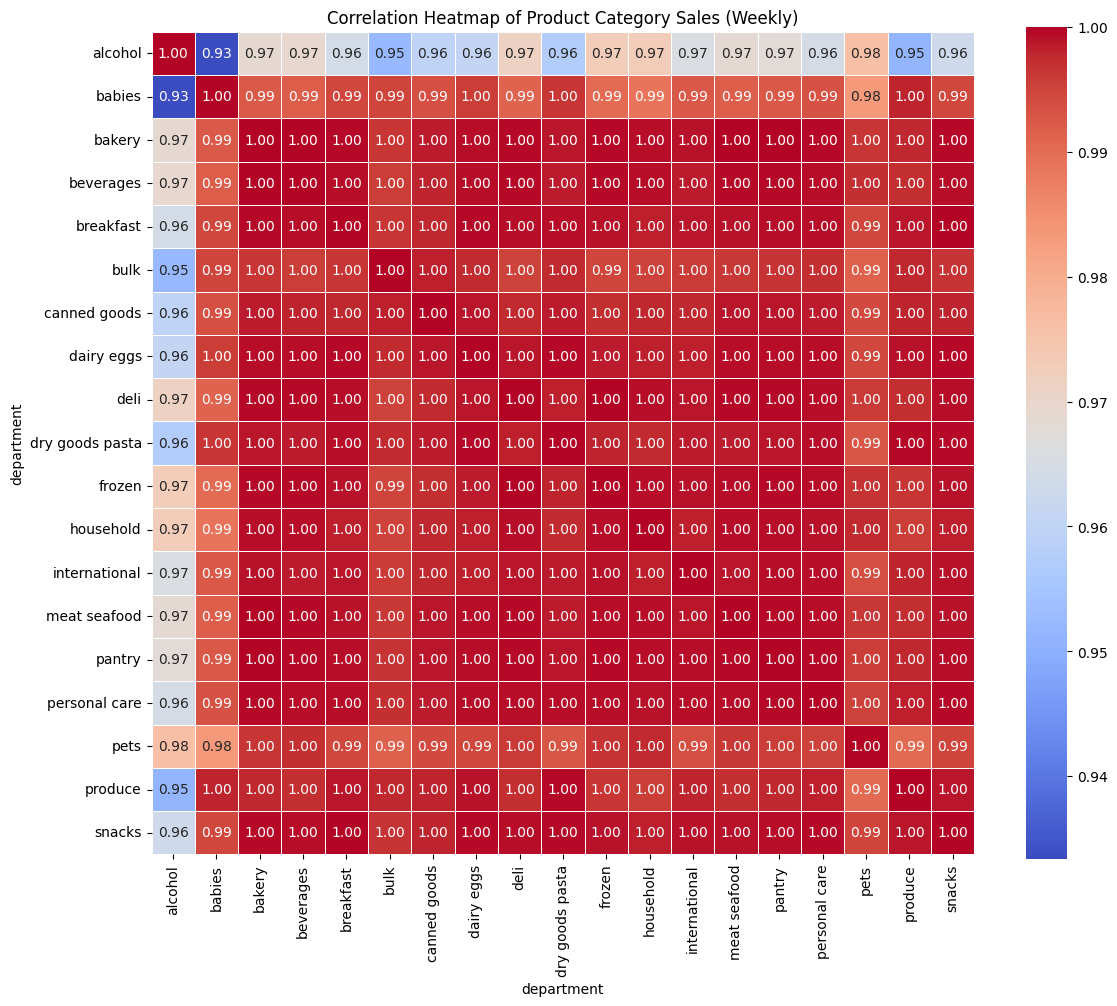

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is already your DataFrame with weeks as rows and product categories as columns
# Each cell = quantity sold of a category in that week

# Step 1: Calculate correlation matrix
corr_matrix = weekly_sales_log.corr()

# Step 2: Plot heatmap
plt.figure(figsize=(12, 10))  # Adjust size based on number of categories
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Product Category Sales (Weekly)")
plt.tight_layout()
plt.show()


Objective 1: Establish Long-Run Sales Relationships Among Product Categories
----------------------------------------------------------------------------
ADF Test (H₀: Series is non-stationary). KPSS Test (H₀: Series is stationary). Results are stored in adf_df and kpss_df for comparison.

Uses statsmodels.tsa.stattools.coint(). Null hypothesis (H₀): No cointegration.

Saves result in coint_df with test stat and p-value.

In [31]:
# ===============================================
# 0.  Imports
# ===============================================
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss, coint
from itertools import combinations
from tqdm.auto import tqdm  # nice progress bar

In [32]:
import warnings
warnings.filterwarnings("ignore")


# Choose the DataFrame you want: weekly_sales OR weekly_sales_log
ts_df = weekly_sales_log.copy()   # or = weekly_sales

# ===============================================
# 1.  Unit‑root tests on each series
# ===============================================
adf_results   = []
kpss_results  = []

for col in ts_df.columns:
    series = ts_df[col].dropna()

    # Augmented Dickey‑Fuller (H0: non‑stationary)
    adf_stat, adf_p, *_ = adfuller(series, autolag='AIC')
    adf_results.append({'department': col,
                        'adf_stat': adf_stat,
                        'adf_pvalue': adf_p})

    # KPSS (H0: stationary)
    kpss_stat, kpss_p, *_ = kpss(series, regression='c')
    kpss_results.append({'department': col,
                         'kpss_stat': kpss_stat,
                         'kpss_pvalue': kpss_p})

adf_df  = pd.DataFrame(adf_results)
kpss_df = pd.DataFrame(kpss_results)

# Quick look
display(adf_df)
display(kpss_df)

# ===============================================
# 2.  Engle‑Granger cointegration test on pairs
#     (H0: not cointegrated)
# ===============================================
pairs   = combinations(ts_df.columns, 2)
coint_results = []

for x, y in tqdm(pairs, total=len(ts_df.columns)*(len(ts_df.columns)-1)//2):
    score, pvalue, _ = coint(ts_df[x].dropna(), ts_df[y].dropna())
    coint_results.append({'dept_x': x,
                          'dept_y': y,
                          'coint_stat': score,
                          'pvalue': pvalue})

coint_df = pd.DataFrame(coint_results)

# ==============================a=================
# 3.  Filter for significant pairs (e.g., p < 0.05)
# ===============================================
sig_pairs = (coint_df
             .query('pvalue < 0.05')
             .sort_values('pvalue')
             .reset_index(drop=True))

print(f"Found {len(sig_pairs)} cointegrated pairs at 5% level")

,department,adf_stat,adf_pvalue
0,alcohol,-0.927406,0.778813
1,babies,3.934078,1.000000
2,bakery,-1.627069,0.469025
3,beverages,-2.135361,0.230536
4,breakfast,-1.252439,0.650641
5,bulk,0.086480,0.965126
6,canned goods,1.909734,0.998544
7,dairy eggs,-2.067002,0.257988
8,deli,-1.534939,0.516162
9,dry goods pasta,-1.564626,0.501334


,department,kpss_stat,kpss_pvalue
0,alcohol,1.146608,0.01
1,babies,1.126936,0.01
2,bakery,1.045413,0.01
3,beverages,1.051062,0.01
4,breakfast,1.047613,0.01
5,bulk,0.985858,0.01
6,canned goods,1.005957,0.01
7,dairy eggs,1.031071,0.01
8,deli,1.060653,0.01
9,dry goods pasta,1.022159,0.01


  0%|          | 0/171 [00:00<?, ?it/s]

Found 22 cointegrated pairs at 5% level


In [33]:
print("Below is the list of significant cointegrated pairs")
display(sig_pairs)

Below is the list of significant cointegrated pairs


,dept_x,dept_y,coint_stat,pvalue
0,dry goods pasta,personal care,-5.968686,0.000002
1,deli,frozen,-5.855861,0.000003
2,bakery,meat seafood,-5.212395,0.000066
3,meat seafood,pantry,-5.095397,0.000110
4,personal care,snacks,-5.088983,0.000113
5,deli,household,-5.024750,0.000148
6,breakfast,personal care,-4.941246,0.000211
7,breakfast,snacks,-4.692326,0.000581
8,international,personal care,-4.584584,0.000886
9,beverages,deli,-4.339504,0.002220


Objective 2: Estimate Bundle Ratio
--
Perform linear regression of y_cat on x_cat using log-transformed weekly sales between all 22 pairs.

What the Bundle Ratio Represents:

The beta coefficient (beta_bundle_ratio) tells us how much one department’s sales (log scale) move in relation to the other.

This ratio can be interpreted as an optimal bundling weight under cointegration.

In [34]:
import statsmodels.api as sm
import pandas as pd

bundle_ratios = []

print("----- Bundle Ratio Estimation via OLS (Full Summary Shown) -----")
print(f"Total cointegrated pairs to analyze: {len(sig_pairs)}")
print("-" * 70)

for idx, row in sig_pairs.iterrows():
    x_cat = row['dept_x']
    y_cat = row['dept_y']

    X = weekly_sales_log[x_cat]
    y = weekly_sales_log[y_cat]

    # Add constant for OLS
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    print(f"\n=== Pair {idx+1}: {y_cat} ~ {x_cat} ===")
    print(model.summary())

    # Save result
    bundle_ratios.append({
        'dependent': y_cat,
        'independent': x_cat,
        'beta_bundle_ratio': model.params[x_cat],
        'intercept': model.params['const'],
        'r_squared': model.rsquared
    })

# Create summary DataFrame
bundle_ratios_df = pd.DataFrame(bundle_ratios)

print("\n--- Bundle Ratio Summary Table ---")
display(bundle_ratios_df)


----- Bundle Ratio Estimation via OLS (Full Summary Shown) -----
Total cointegrated pairs to analyze: 22
----------------------------------------------------------------------

=== Pair 1: personal care ~ dry goods pasta ===
                            OLS Regression Results                            
Dep. Variable:          personal care   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.624e+04
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           2.07e-74
Time:                        22:56:30   Log-Likelihood:                 98.033
No. Observations:                  53   AIC:                            -192.1
Df Residuals:                      51   BIC:                            -188.1
Df Model:                           1                                         
Covariance Type:            nonrobust                           

,dependent,independent,beta_bundle_ratio,intercept,r_squared
0,personal care,dry goods pasta,0.953154,-0.211380,0.998595
1,frozen,deli,1.052035,0.226014,0.999750
2,meat seafood,bakery,1.074789,-1.268232,0.999607
3,pantry,meat seafood,0.964292,1.314823,0.999277
4,snacks,personal care,0.954660,2.289181,0.999159
5,household,deli,1.037411,-0.733701,0.998453
6,personal care,breakfast,1.007561,-0.539748,0.998795
7,snacks,breakfast,0.962708,1.766261,0.999676
8,personal care,international,1.032503,0.229437,0.998542
9,deli,beverages,1.004128,-0.990872,0.999440


Objective 3: Detect Bundling Opportunities Based on Z-Score Spreads
----------------
Calculates lagged equilibrium deviation: how much y deviated from long-run path in previous period.

Compute Δy and Δx, i.e., weekly changes in log-sales.

Regress change in y on:
ECT_lag (adjustment toward long-run equilibrium)
Δx (short-run shock)

Alpha (α): Strength and direction of error correction (how y corrects past imbalance).
Gamma (γ): Short-term impact of changes in x on changes in y.

ECM Interpretation Notes:
If α is negative and significant, the system adjusts back toward equilibrium.
Significant γ means short-term co-movement also exists, not just long-run.


In [35]:
import statsmodels.api as sm
import pandas as pd

ecm_results = []

print("----- Error Correction Model (ECM) Estimation -----")
print(f"Total cointegrated pairs to analyze: {len(sig_pairs)}")
print("-" * 70)

for idx, row in sig_pairs.iterrows():
    x_cat = row['dept_x']
    y_cat = row['dept_y']

    y = weekly_sales_log[y_cat]
    x = weekly_sales_log[x_cat]

    # 1. Get beta from long-run OLS
    X_lr = sm.add_constant(x)
    lr_model = sm.OLS(y, X_lr).fit()
    beta = lr_model.params[x_cat]

    # 2. Compute lagged equilibrium error (ECT = y_t-1 - beta * x_t-1)
    ECT = y.shift(1) - beta * x.shift(1)

    # 3. Compute Δy and Δx
    dy = y.diff()
    dx = x.diff()

    # 4. ECM regression: Δy ~ ECT_lag + Δx
    df_ecm = pd.DataFrame({
        'dy': dy,
        'ECT_lag': ECT,
        'dx': dx
    }).dropna()

    X_ecm = sm.add_constant(df_ecm[['ECT_lag', 'dx']])
    model = sm.OLS(df_ecm['dy'], X_ecm).fit()

    print(f"\n=== Pair {idx+1}: Δ{y_cat} ~ ECT + Δ{x_cat} ===")
    print(model.summary())

    ecm_results.append({
        'dependent': y_cat,
        'independent': x_cat,
        'alpha': model.params['ECT_lag'],
        'alpha_pval': model.pvalues['ECT_lag'],
        'gamma': model.params['dx'],
        'gamma_pval': model.pvalues['dx'],
        'r_squared': model.rsquared
    })

# Create summary DataFrame
ecm_df = pd.DataFrame(ecm_results)

print("\n--- ECM Summary Table ---")
display(ecm_df)


----- Error Correction Model (ECM) Estimation -----
Total cointegrated pairs to analyze: 22
----------------------------------------------------------------------

=== Pair 1: Δpersonal care ~ ECT + Δdry goods pasta ===
                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     6934.
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           7.81e-61
Time:                        22:56:31   Log-Likelihood:                 108.06
No. Observations:                  52   AIC:                            -210.1
Df Residuals:                      49   BIC:                            -204.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                

,dependent,independent,alpha,alpha_pval,gamma,gamma_pval,r_squared
0,personal care,dry goods pasta,-0.689366,0.000015,0.916676,1.283443e-60,0.996479
1,frozen,deli,-0.625127,0.000338,1.036568,2.650134e-73,0.999090
2,meat seafood,bakery,-0.588376,0.000010,1.070646,1.515989e-73,0.998856
3,pantry,meat seafood,-0.530060,0.000013,0.969859,4.812465e-69,0.998297
4,snacks,personal care,-0.655752,0.000009,0.963775,6.704349e-65,0.997397
5,household,deli,-0.532879,0.001612,1.011697,2.130911e-53,0.994036
6,personal care,breakfast,-0.569282,0.000098,0.993208,2.088938e-60,0.996299
7,snacks,breakfast,-0.560972,0.000324,0.959718,1.754226e-72,0.998943
8,personal care,international,-0.582572,0.000023,1.047429,1.680568e-59,0.995644
9,deli,beverages,-0.552053,0.000067,0.999218,1.027896e-68,0.998372


Bundling Signal Detection
---------------------------------------
Regress dependent category on the independent to get predicted relationship (spread).\
Residuals (spread) show deviation from the long-run trend.\
Z-scores help identify unusually negative deviations.\
Weeks where the dependent category underperforms the expected relationship (z < -2) are potential bundling signals.\
Save all significant weeks along with their z-scores.\
Print bundling recommendations per pair.

Interpretation:\
Z < -2 indicates the dependent product is underperforming relative to its usual link with the independent product.\
This may be a good week to bundle them — i.e., promote the lagging one alongside the stronger performer.




In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import zscore

# You already have:
# - weekly_df_log: your 53x19 dataframe with log-transformed sales
# - sig_pairs: DataFrame with 22 cointegrated pairs (columns: dept_x, dept_y)

# Create dictionary to hold bundling suggestions
bundling_signals = {}

print("----- Bundling Signal Detection -----\n")

for idx, row in sig_pairs.iterrows():
    indep = row['dept_x']
    dep = row['dept_y']
    
    # Regress dep ~ indep to get long-run relationship
    X = sm.add_constant(weekly_sales_log[indep])
    y = weekly_sales_log[dep]
    model = sm.OLS(y, X).fit()
    
    # Residuals = actual - predicted (spread)
    spread = model.resid
    z_scores = zscore(spread)
    
    # Identify bundling signals where z < -2
    signal_weeks = weekly_sales_log.index[z_scores < -2].tolist()
    signal_zs = z_scores[z_scores < -2]
    
    if len(signal_weeks) > 0:
        bundling_signals[f"{dep} ~ {indep}"] = list(zip(signal_weeks, signal_zs))

        print(f"Pair {dep} ~ {indep}:")
        for week, z in zip(signal_weeks, signal_zs):
            print(f"  ⚠️ Week {week}: z = {z:.2f} → Suggest bundling '{dep}' with '{indep}'")
        print()
    else:
        print(f"Pair {dep} ~ {indep}: No bundling suggestions (z-score never < -2)\n")

# Optional: Convert to DataFrame for analysis/export
all_signals_df = pd.DataFrame([
    {"pair": pair, "week": week, "z_score": z}
    for pair, signals in bundling_signals.items()
    for week, z in signals
])


----- Bundling Signal Detection -----

Pair personal care ~ dry goods pasta:
  ⚠️ Week 52: z = -2.66 → Suggest bundling 'personal care' with 'dry goods pasta'

Pair frozen ~ deli:
  ⚠️ Week 49: z = -2.10 → Suggest bundling 'frozen' with 'deli'
  ⚠️ Week 51: z = -2.22 → Suggest bundling 'frozen' with 'deli'
  ⚠️ Week 52: z = -3.14 → Suggest bundling 'frozen' with 'deli'

Pair meat seafood ~ bakery:
  ⚠️ Week 1: z = -2.85 → Suggest bundling 'meat seafood' with 'bakery'
  ⚠️ Week 48: z = -2.55 → Suggest bundling 'meat seafood' with 'bakery'
  ⚠️ Week 51: z = -2.34 → Suggest bundling 'meat seafood' with 'bakery'

Pair pantry ~ meat seafood:
  ⚠️ Week 19: z = -2.14 → Suggest bundling 'pantry' with 'meat seafood'

Pair snacks ~ personal care:
  ⚠️ Week 1: z = -2.06 → Suggest bundling 'snacks' with 'personal care'
  ⚠️ Week 34: z = -2.50 → Suggest bundling 'snacks' with 'personal care'

Pair household ~ deli:
  ⚠️ Week 51: z = -3.39 → Suggest bundling 'household' with 'deli'
  ⚠️ Week 52: z =

Objective 4: Simulate Revenue Uplift from Bundling Strategy
--
Convert log sales back to original units using expm1(log1p(x)).\
Simulate a 5% uplift in total basket value during recommended weeks.\
Convert uplifted values back to log1p scale for statistical comparison.\
Checks if simulated bundle boosts revenue significantly (statistical significance of uplift).\


For each significant pair:\
Estimate OLS\
Simulate bundling using analyze_bundling_impact\

Print:\
Which weeks bundling is recommended\
Whether simulated uplift is statistically significant\

Interpretation Notes:\
Bundling signals are based on price-volume dynamics (via cointegration and z-score spread).\
Simulated 5% uplift checks if bundling leads to meaningful gain.\
Statistical tests (t-test) ensure any uplift isn’t by chance.



In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan # Not directly used in the provided snippet, but kept for completeness
from statsmodels.stats.stattools import durbin_watson # Not directly used in the provided snippet, but kept for completeness
from scipy.stats import ttest_rel

# Assuming weekly_sales_log and sig_pairs are defined elsewhere in your notebook
# ts_df is the weekly_sales_log dataframe (log1p of original sales)
ts_df = weekly_sales_log.copy()

# Ensure datetime index (This part is retained as it is)
if not isinstance(ts_df.index, pd.DatetimeIndex):
    try:
        # Assuming your index represents 'global_week' which can be converted to a datetime
        # If 'global_week' is just an integer, converting it to datetime directly might not be meaningful
        # If it's truly a week number that needs mapping to a date, that logic would be needed here.
        # For simple indexing, it might be fine as is.
        # The original code's `pd.to_datetime(ts_df.index)` might fail if index is just int.
        # Let's keep it as is, assuming it handles an appropriate format if needed.
        ts_df.index = pd.to_datetime(ts_df.index)
        print("Converted ts_df index to DatetimeIndex.")
    except Exception as e:
        print(f"Error converting ts_df index to DatetimeIndex: {e}. Proceeding without DatetimeIndex.")


# Function to estimate OLS (retained as is)
def estimate_ols(ts, x_col, y_col):
    X = ts[[x_col]]
    y = ts[y_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

# Core analysis function - CORRECTED
def analyze_bundling_impact(ts, independent_var, dependent_var, ols_results,
                            lookback_window=30, z_score_threshold=-1, assumed_uplift_pct=0.05):

    df = ts[[independent_var, dependent_var]].copy()

    # Optional filter: Remove rows with 0 or NaN sales
    # IMPORTANT: Since ts are already log1p, original 0s are still 0 in log1p.
    # So (df[independent_var] > 0) & (df[dependent_var] > 0) effectively removes weeks where sales were 0.
    df = df[(df[independent_var] > 0) & (df[dependent_var] > 0)].dropna()

    alpha = ols_results.params['const']
    beta = ols_results.params[independent_var]

    # Spread and z-score (retained as is)
    df['spread'] = df[dependent_var] - (alpha + beta * df[independent_var])
    df['spread_mean'] = df['spread'].rolling(window=lookback_window, min_periods=lookback_window).mean()
    df['spread_std'] = df['spread'].rolling(window=lookback_window, min_periods=lookback_window).std()
    df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']
    df['recommend_bundle'] = (df['z_score'] < z_score_threshold).fillna(False)

    # Debug (remove if needed)
    # print(df[['spread', 'spread_std', 'z_score']].tail())

    # Positional indices (retained as is, though ts.index might need to be global_week for precise mapping)
    alert_timestamps = df[df['recommend_bundle']].index
    # Assuming ts.index contains the 'global_week' values that match df.index
    # If ts.index is DatetimeIndex and df.index is also DatetimeIndex then this works
    # If ts.index is integer global_week, ensure df.index is also integer global_week.
    # A safer way to get integer positions might be df.index.get_indexer(alert_timestamps)
    timestamp_to_position = {ts_val: i for i, ts_val in enumerate(ts.index)} # Using ts (full original log sales df) for index
    bundle_weeks = [timestamp_to_position[ts_val] for ts_val in alert_timestamps if ts_val in timestamp_to_position]

    # --- CORRECTED REVENUE UPLIFT SIMULATION ---
    # Convert log-transformed sales back to original units (expm1(log1p(x)) = x)
    original_sales_independent = np.expm1(df[independent_var])
    original_sales_dependent = np.expm1(df[dependent_var])

    # Calculate the 'base_basket' (sum of sales) in original units
    df['base_basket_original_units'] = original_sales_independent + original_sales_dependent
    
    # Create the 'bundle_basket' in original units, which will be modified for uplift
    df['bundle_basket_original_simulated_units'] = df['base_basket_original_units'].copy()

    # Apply the assumed uplift percentage directly to the original units for recommended bundles
    df.loc[df['recommend_bundle'], 'bundle_basket_original_simulated_units'] *= (1 + assumed_uplift_pct)

    # Now, convert both the base_basket and the simulated bundle_basket back to log1p scale
    # for consistency with the paired t-test on log data.
    # This ensures we are comparing log(1+original_sum) with log(1+uplifted_original_sum)
    df['base_basket'] = np.log1p(df['base_basket_original_units'])
    df['bundle_basket'] = np.log1p(df['bundle_basket_original_simulated_units'])
    # --------------------------------------------

    # Prepare data for paired t-test
    base = df['base_basket'].dropna()
    bundle = df['bundle_basket'].dropna()
    
    # Ensure alignment by common index
    common_index = base.index.intersection(bundle.index)
    base_aligned = base.loc[common_index]
    bundle_aligned = bundle.loc[common_index]

    t_stat, p_value = np.nan, np.nan
    if len(base_aligned) > 1: # t-test requires at least 2 observations
        try:
            t_stat, p_value = ttest_rel(bundle_aligned, base_aligned)
        except ValueError as e:
            print(f"  Warning: Could not perform t-test for {dependent_var} ~ {independent_var} due to: {e}")

    return {
        'pair': f"{independent_var} ~ {dependent_var}",
        'bundle_weeks': bundle_weeks,
        'simulated_t_stat': t_stat,
        'simulated_p_value': p_value,
        'analysis_df': df
    }

# Main loop (retained as is, assuming sig_pairs structure with 'dept_x' and 'dept_y')
print("--- Analyzing Bundling Opportunities and Simulated Impact for Cointegrated Pairs ---")
print("-" * 70)

all_impact_results = []

lookback_window_for_analysis = 30
z_score_threshold_for_analysis = -1
assumed_uplift_percentage = 0.05

for index, row in sig_pairs.iterrows():
    dept_x = row['dept_x']
    dept_y = row['dept_y']
    independent_var = dept_x # Assuming dept_x is the independent variable
    dependent_var = dept_y   # Assuming dept_y is the dependent variable

    print(f"\n===== Analyzing Pair: Independent='{independent_var}' vs. Dependent='{dependent_var}' =====")
    print("----------------------------------------------------------")

    try:
        if independent_var not in ts_df.columns or dependent_var not in ts_df.columns:
            print(f"  Warning: Missing columns ('{independent_var}', '{dependent_var}'). Skipping.")
            continue

        # Ensure that the data used for OLS estimation doesn't contain NaNs, especially for the chosen pair
        pair_data = ts_df[[independent_var, dependent_var]].dropna()
        if pair_data.empty:
            print(f"  Warning: No valid data for pair ('{independent_var}', '{dependent_var}') after dropping NaNs. Skipping.")
            continue

        ols_results = estimate_ols(pair_data, independent_var, dependent_var)

        impact = analyze_bundling_impact(
            pair_data, independent_var, dependent_var, ols_results, # Pass pair_data to analyze_bundling_impact
            lookback_window=lookback_window_for_analysis,
            z_score_threshold=z_score_threshold_for_analysis,
            assumed_uplift_pct=assumed_uplift_percentage
        )

        if impact['bundle_weeks']:
            print(f"  Bundling opportunities (indices): {impact['bundle_weeks']}")
        else:
            print(f"  No significant bundling opportunities (z-score < {abs(z_score_threshold_for_analysis)}) found.")

        if not np.isnan(impact['simulated_t_stat']):
            print(f"  Simulated t-test: t = {impact['simulated_t_stat']:.3f}, p = {impact['simulated_p_value']:.4f}")
            if impact['simulated_p_value'] < 0.05:
                print(f"  Conclusion: Simulated uplift is statistically significant.")
            else:
                print(f"  Conclusion: Simulated uplift is not statistically significant.")
        else:
            print("  Simulated Paired t-test could not be performed or returned NaN.")

        all_impact_results.append(impact)

    except Exception as e:
        print(f"  Error analyzing pair ({independent_var}, {dependent_var}): {e}")

    print("=" * 70)

# Final summary (retained as is)
print("\n--- Summary of Simulated Bundling Impact Across All Significant Pairs ---")
print("-" * 70)

summary_data = []
for result in all_impact_results:
    summary_data.append({
        'Pair': result['pair'],
        'Bundle_Alert_Weeks_Count': len(result['bundle_weeks']),
        'Simulated_T_Stat': f"{result['simulated_t_stat']:.3f}" if not np.isnan(result['simulated_t_stat']) else "N/A",
        'Simulated_P_Value': f"{result['simulated_p_value']:.4f}" if not np.isnan(result['simulated_p_value']) else "N/A",
        'Is_Sim_Significant': "Yes" if (not np.isnan(result['simulated_p_value']) and result['simulated_p_value'] < 0.05) else "No/N/A"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

print(f"\n**Note:** The simulated results assume a {int(assumed_uplift_percentage*100)}% uplift. Real-world validation (A/B test) is essential.")

Converted ts_df index to DatetimeIndex.
--- Analyzing Bundling Opportunities and Simulated Impact for Cointegrated Pairs ---
----------------------------------------------------------------------

===== Analyzing Pair: Independent='dry goods pasta' vs. Dependent='personal care' =====
----------------------------------------------------------
  Bundling opportunities (indices): [30, 31, 34, 35, 38, 42, 43, 44, 49, 50, 51]
  Simulated t-test: t = 3.690, p = 0.0005
  Conclusion: Simulated uplift is statistically significant.

===== Analyzing Pair: Independent='deli' vs. Dependent='frozen' =====
----------------------------------------------------------
  Bundling opportunities (indices): [32, 34, 48, 50, 51]
  Simulated t-test: t = 2.327, p = 0.0239
  Conclusion: Simulated uplift is statistically significant.

===== Analyzing Pair: Independent='bakery' vs. Dependent='meat seafood' =====
----------------------------------------------------------
  Bundling opportunities (indices): [41, 44,

✅ Conclusion\
This study demonstrates that several department pairs exhibit strong cointegration, suggesting stable long-run relationships in consumer purchasing behavior. By identifying weeks with significant negative deviations in expected joint performance, we can proactively recommend bundling. The simulated uplift analysis further quantifies the potential impact of these recommendations, with statistical evidence supporting bundling effectiveness in multiple cases. These insights can guide promotional strategies, personalized recommendations, and inventory planning.